In [5]:
# Import dependencies
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
import datetime as dt
import time
import requests
import json
import numpy as np
import sqlalchemy


import matplotlib.pyplot as plt
%matplotlib inline

import locale
locale.setlocale(locale.LC_ALL,'')

from config import apikey

# Dependencies for sending dataframes to sql database
from sqlalchemy import create_engine
from sqlConfig import user, password



### *Using Alpha Vantange API - Find Data for SPY (S&P 500)*

In [6]:
data_frequency = 'MONTHLY'
SPY_ticker = 'SPY'

SPY_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_{data_frequency}&symbol={SPY_ticker}&apikey=' + apikey
SPY_response = requests.get(SPY_url).json()

In [7]:

SPY_dates = []
SPY_close = []

for dates in SPY_response['Monthly Time Series']:

        if dates not in SPY_dates:
            
            # Tech market crash in 2001. 
            #To exclude outlier which contributes bias in data, data beginning 2003 (end of downward trend) will be used.
            if dates >= "2003-01-01":
                
                SPY_dates.append(dates)
                SPY_close.append(SPY_response['Monthly Time Series'][dates]['4. close'])


SPY_data = pd.DataFrame({'Date': SPY_dates, 'SPY_Close': SPY_close})
SPY_data          

,Date,SPY_Close
0,2020-01-07,322.7300
1,2019-12-31,321.8600
2,2019-11-29,314.3100
3,2019-10-31,303.3300
4,2019-09-30,296.7700
...,...,...
200,2003-05-30,96.9500
201,2003-04-30,91.9100
202,2003-03-31,84.7400
203,2003-02-28,84.9000


### *Using Alpha Vantange API - Find data for VBMFX (Total Bond)*

In [8]:
VBMFX_ticker = 'VBMFX'

VBMFX_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_{data_frequency}&symbol={VBMFX_ticker}&apikey=' + apikey
VBMFX_response = requests.get(VBMFX_url).json()

In [9]:
VBMFX_dates = []
VBMFX_close = []

for dates in VBMFX_response['Monthly Time Series']:

        if dates not in VBMFX_dates:
            if dates >= "2003-01-01":
                VBMFX_dates.append(dates)
                VBMFX_close.append(VBMFX_response['Monthly Time Series'][dates]['4. close'])


VBMFX_data = pd.DataFrame({'Date': VBMFX_dates, 'VBMFX_Close': VBMFX_close})
VBMFX_data

,Date,VBMFX_Close
0,2020-01-06,11.1100
1,2019-12-31,11.0500
2,2019-11-29,11.0900
3,2019-10-31,11.1200
4,2019-09-30,11.1200
...,...,...
200,2003-05-30,10.5800
201,2003-04-30,10.4300
202,2003-03-31,10.3800
203,2003-02-28,10.4400


### *Merge SPY and VBMFX DataFrames*

In [10]:
data = SPY_data.merge(VBMFX_data, on='Date')

# Change all column dtypes to datetime or float as appropriate
data['Date'] = pd.to_datetime(data['Date'])
data['SPY_Close'] = pd.to_numeric(data['SPY_Close'])
data['VBMFX_Close'] = pd.to_numeric(data['VBMFX_Close'])

data = data.set_index('Date')

data.dtypes

SPY_Close      float64
VBMFX_Close    float64
dtype: object

In [11]:
data = data.sort_index()
data

,SPY_Close,VBMFX_Close
Date,,
2003-01-31,86.0600,10.34
2003-02-28,84.9000,10.44
2003-03-31,84.7400,10.38
2003-04-30,91.9100,10.43
2003-05-30,96.9500,10.58
...,...,...
2019-08-30,292.4527,11.21
2019-09-30,296.7700,11.12
2019-10-31,303.3300,11.12


### *Calculate 12-Month Percentage Change*

In [12]:
data_12M_Return = data.pct_change(12)
data_12M_Return = data_12M_Return.dropna()

# Update columns to appropriate names
data_12M_Return = data_12M_Return.rename(columns={'SPY_Close': 'SPY_Return','VBMFX_Close': 'VBMFX_Return'})

data_12M_Return

,SPY_Return,VBMFX_Return
Date,,
2004-01-30,0.318615,0.001934
2004-02-27,0.354770,-0.000958
2004-03-31,0.334671,0.007707
2004-04-30,0.207268,-0.026846
2004-05-28,0.164105,-0.048204
...,...,...
2019-08-30,0.007381,0.073755
2019-09-30,0.020810,0.073359
2019-10-31,0.120829,0.083821


### *Calculate 12-Month Rolling Returns for Five New Portfolios*

#### The weight for the portfolios are:
    * Very Aggressive: 100% Stock (SPY)
    * Aggeressive: 80% SPY and 20% Bonds (VBMFX)
    * Moderate: 50% SPY and 50% VBMFX
    * Conservative: 20% SPY and 80% VBMFX
    * Very Conservative: 100% VBMFX

In [13]:
data_12M_Return['Very_Aggressive'] = data_12M_Return.SPY_Return

data_12M_Return['Aggressive'] = .8*data_12M_Return.SPY_Return + .2* data_12M_Return.VBMFX_Return

data_12M_Return['Moderate'] = .5*data_12M_Return.SPY_Return + .5* data_12M_Return.VBMFX_Return

data_12M_Return['Conservative'] = .2*data_12M_Return.SPY_Return + .8* data_12M_Return.VBMFX_Return

data_12M_Return['Very_Conservative'] =  data_12M_Return.VBMFX_Return

data_12M_Return

,SPY_Return,VBMFX_Return,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
Date,,,,,,,
2004-01-30,0.318615,0.001934,0.318615,0.255279,0.160275,0.065270,0.001934
2004-02-27,0.354770,-0.000958,0.354770,0.283625,0.176906,0.070188,-0.000958
2004-03-31,0.334671,0.007707,0.334671,0.269278,0.171189,0.073100,0.007707
2004-04-30,0.207268,-0.026846,0.207268,0.160445,0.090211,0.019977,-0.026846
2004-05-28,0.164105,-0.048204,0.164105,0.121643,0.057951,-0.005742,-0.048204
...,...,...,...,...,...,...,...
2019-08-30,0.007381,0.073755,0.007381,0.020656,0.040568,0.060480,0.073755
2019-09-30,0.020810,0.073359,0.020810,0.031320,0.047085,0.062849,0.073359
2019-10-31,0.120829,0.083821,0.120829,0.113427,0.102325,0.091222,0.083821


In [14]:
# Drop unnecessary columns

data_12M_Return = data_12M_Return.drop(columns=['SPY_Return', 'VBMFX_Return'])

data_12M_Return

,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
Date,,,,,
2004-01-30,0.318615,0.255279,0.160275,0.065270,0.001934
2004-02-27,0.354770,0.283625,0.176906,0.070188,-0.000958
2004-03-31,0.334671,0.269278,0.171189,0.073100,0.007707
2004-04-30,0.207268,0.160445,0.090211,0.019977,-0.026846
2004-05-28,0.164105,0.121643,0.057951,-0.005742,-0.048204
...,...,...,...,...,...
2019-08-30,0.007381,0.020656,0.040568,0.060480,0.073755
2019-09-30,0.020810,0.031320,0.047085,0.062849,0.073359
2019-10-31,0.120829,0.113427,0.102325,0.091222,0.083821


### *Create Summary Statics for the Five Portfolios*

Mean, STD and Max will be used for the model calculations

In [15]:
data_summary = data_12M_Return.describe()

data_summary

,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
count,192.000000,192.000000,192.000000,192.000000,192.000000
mean,0.083490,0.067506,0.043530,0.019554,0.003570
std,0.147658,0.118420,0.075651,0.038279,0.029540
min,-0.447541,-0.363486,-0.237403,-0.111319,-0.056200
25%,0.031594,0.030721,0.019771,-0.000007,-0.019016
50%,0.109241,0.088634,0.053453,0.021531,0.003810
75%,0.155522,0.122171,0.080124,0.042480,0.021414
max,0.497903,0.407932,0.272976,0.138019,0.090814


In [17]:
# Drop unnecessary rows
data_summary = data_summary.drop(['count', 'min', '25%', '50%', '75%'])

data_summary

,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
mean,0.083490,0.067506,0.043530,0.019554,0.003570
std,0.147658,0.118420,0.075651,0.038279,0.029540
max,0.497903,0.407932,0.272976,0.138019,0.090814


# Send DataFrames to PostgreSQL

In [20]:
# Prepare to send dataframe to postgresSQL database. Create connection
rds_connection_string = user + ":" + password + "@localhost:5432/investmentDB"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [21]:

# Check for tables
engine.table_names()

[]

In [22]:

# Send the 12M dataframe to postgreSQL
data_12M_Return.to_sql(name='12M_Return', con=engine, if_exists='append', index=True)

In [23]:

# Send the Summary dataframe to postgreSQL
data_summary.to_sql(name='data_summary', con=engine, if_exists='append', index=True)

In [24]:

# Check for tables
engine.table_names()

['12M_Return', 'data_summary']

# Retrieve Data From Postgres

In [58]:


summary_df = pd.read_sql_query("select * from data_summary",con=engine)
summary_df=summary_df.set_index("index")
summary_df = summary_df[['Very_Conservative','Conservative','Moderate','Aggressive','Very_Aggressive']]
summary_df

,Very_Conservative,Conservative,Moderate,Aggressive,Very_Aggressive
index,,,,,
mean,0.003570,0.019554,0.043530,0.067506,0.083490
std,0.029540,0.038279,0.075651,0.118420,0.147658
max,0.090814,0.138019,0.272976,0.407932,0.497903


In [60]:
mean_list = summary_df.loc['mean',['Very_Conservative','Conservative','Moderate','Aggressive','Very_Aggressive']]
mean_list = mean_list.tolist()
print(mean_list)


std_list = summary_df.loc['std',['Very_Conservative','Conservative','Moderate','Aggressive','Very_Aggressive']]
std_list = std_list.tolist()
print(std_list)

max_list =summary_df.loc['max',['Very_Conservative','Conservative','Moderate','Aggressive','Very_Aggressive']]
max_list = max_list.tolist()
print(max_list)


[0.0035698651110875, 0.0195538145338641, 0.0435297386680289, 0.0675056628021937, 0.0834896122249703]
[0.029539973198266, 0.0382792697676384, 0.0756511604450881, 0.118420445445144, 0.147657629983549]
[0.0908141962421711, 0.138019122869657, 0.272975735102071, 0.407932347334484, 0.497903422156093]


### *Below Calculates the Ending Portfolio Value Based on:*
    * Initial investment (pv)
    * Additions
    * Time horizon
    * Expected rate of returns
##### This will NOT be used as the market returns are never uniform

                     High Value     Low Value
Portfolios                                   
Very_Conservative  16125.456175  14661.035833
Conservative       16699.865658  14394.964848
Moderate           17601.425304  12796.663293
Aggressive         18552.836919  10984.534605
Very_Aggressive    19215.898944   9648.237100
AxesSubplot(0.125,0.125;0.775x0.755)


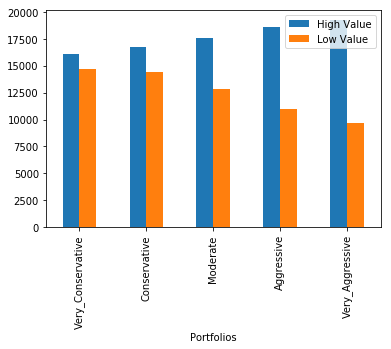

In [61]:
#This is calculating the ending portfolio value based on the initial investment, additions
#time horizon, expected rate of returns.
# We will not be using this as the market returns are never uniform.

#aggretion = 0
# pv_val = int(input())
# addition_val = int(input())
# time_val = int(input())
Portfolios = ['Very_Conservative','Conservative','Moderate','Aggressive','Very_Aggressive']
big_lst= []
for x in range(0,5):
    pv = 1000
    time_horizon = 5
    i = mean_list[x]
    additions = 3000
    lst=[]
    for year in range(time_horizon):
        ending = pv * (1+i) + additions
        #print(locale.currency(ending, grouping=True))
        pv = ending
        lst.append(pv)

    high_value = lst[-1]   
    low_value = high_value *(1-max_list[x])
    new_lst = [Portfolios[x],high_value, low_value]
    big_lst.append(new_lst)
data = pd.DataFrame(big_lst)

data = data.rename(columns={0: 'Portfolios', 1: 'High Value',2:'Low Value'})

data = data.set_index('Portfolios')
ax = data.plot.bar()
print(data)
print(ax)

#### *For the web app version, PV, annual_investment and time_horizon will be grabbed from user input.*
#### *Expected_return and volatility will be grabbed from the portfolio selected.*

In [86]:
sim = DataFrame() #<------ IS THERE A REASON TO USE DataFrame() INSTEAD OF pd.DataFrame()?
iterations = 100

Portfolios = ['Very_Conservative','Conservative','Moderate','Aggressive','Very_Aggressive']
select_portfolio = input(Portfolios)
for x in range(iterations):
    
    expected_return = summary_df.iloc[0][select_portfolio]#.0867 #Value based on selection
    volatility = summary_df.iloc[1][select_portfolio]#.17 #Value based on selection
    time_horizon = 30 #Input Value
    pv = 10000 #Input Value
    annual_investment = 10000 #Input Value
    stream = []
    
    for i in range(time_horizon):
        
        end = round(pv * (1 + np.random.normal(expected_return,volatility)) + annual_investment,2)
        
        stream.append(end)

        pv = end

    
    sim[x] = stream

['Very_Conservative', 'Conservative', 'Moderate', 'Aggressive', 'Very_Aggressive']Moderate


In [87]:
first_ten = list(range(10))
sim[first_ten]

,0,1,2,3,4,5,6,7,8,9
0,20995.63,20574.01,20349.37,20302.01,19844.81,20062.58,20676.36,19811.41,21094.66,19963.06
1,30059.49,30498.77,31754.91,30261.75,31230.27,32930.98,31745.09,31989.67,34648.53,31807.71
2,39471.85,46371.03,46342.96,42990.76,45372.99,43599.25,41235.06,42252.16,44366.82,45622.73
3,52692.02,59173.85,56389.48,55016.16,62004.48,50886.56,49345.69,57719.34,55721.33,57287.30
4,59693.71,73214.05,67193.49,61673.11,68371.24,64359.48,65861.89,72098.80,60302.48,75358.41
5,68311.69,82636.53,77954.38,71241.88,84226.11,77017.36,76157.92,85033.38,71273.37,85399.00
6,89134.82,107554.61,94444.43,90676.21,98251.49,87574.53,88423.59,98734.20,77221.20,96623.22
7,100668.70,121148.87,105391.39,94328.31,120603.62,106384.05,95427.27,108001.67,95517.17,119187.61
8,103562.16,138272.84,133587.04,102912.29,132721.07,139955.44,116199.19,122112.73,104996.99,122386.22
9,122447.00,147595.28,149236.68,117430.37,132634.10,141611.96,139242.29,141848.26,117795.41,141941.58


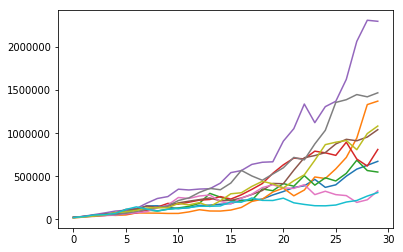

In [65]:
plt.plot(sim[first_ten])
plt.show()

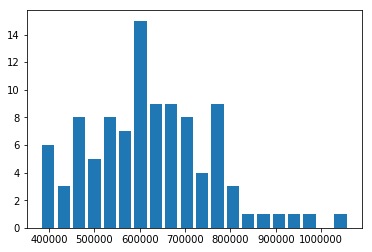

In [88]:
#Sim index values based on 30-1 years to account for Zero Index
ending_values = sim.loc[time_horizon-1]

plt.hist(ending_values, bins=20, rwidth=0.8)
plt.show()

In [67]:
p_tiles = np.percentile(ending_values,[5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95])

for p in range(len(p_tiles)):
    
    l = [5, 10, 15, 20, 25, 50, 25, 20,15, 10, 5]
    print( "{}%-ile: ".format(l[p]).rjust(15),"{}".format(locale.currency(p_tiles[p], grouping=True)))

       5%-ile:  $446,697.70
      10%-ile:  $536,809.62
      15%-ile:  $595,899.18
      20%-ile:  $715,027.36
      25%-ile:  $764,477.16
      50%-ile:  $1,128,352.33
      25%-ile:  $1,489,115.27
      20%-ile:  $1,671,609.61
      15%-ile:  $2,061,000.13
      10%-ile:  $2,211,281.78
       5%-ile:  $2,588,319.13


In [69]:
# Calculate success rate

prob_of_success = len(ending_values[ending_values>2000000]) / len(ending_values)

f"The rate of success is {prob_of_success*100} %"

'The rate of success is 17.0 %'